<a href="https://colab.research.google.com/github/a1rishav/ds_ml/blob/main/cnn/CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Notebook Structure

- Load dataset
- Import libraries
- Visualize data
- Create model 1 (preprocessing + 3 conv layer + Flatten + 2 Dense)
  - overfitted
- Create model 2 (augmentation + preprocessing + 3 conv layer + Flatten + 2 Dense)
  - deeper model with dropouts --> underfitted
- Handle class imbalance with Augmentor  
- Create model 3 (augmentation + preprocessing + 6 conv layer + Flatten + 2 Dense)
  - depper model with 1x1 and 5x5 convolutions --> better accuracy

### Load dataset


In [1]:
# Importing Skin Cancer Data

from google.colab import drive
drive.mount('/content/gdrive')

base_path = "/content/gdrive/MyDrive/ai/tensorflow_keras/cnn/skin_cancer_assignment"

!ls $base_path

Mounted at /content/gdrive
 CNN_assignment.zip
'CNN_assignment.zip (Unzipped Files)'
 CNN_Skin_Cancer.ipynb
 Starter_code_Assignment_CNN_Skin_Cancer.ipynb
 Test
 Train


### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
os.chdir(base_path)
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [4]:
# count images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [17]:
# Code to delete output directory
# import shutil
# for dir in os.listdir(data_dir_train):
#   path = os.path.join(data_dir_train, dir, 'output') 
#   print(path)
#   shutil.rmtree(path)


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
validation_split=0.2

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=validation_split,
    subset="training",
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=validation_split,
    subset="validation",
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [24]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

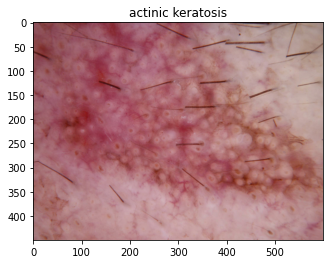

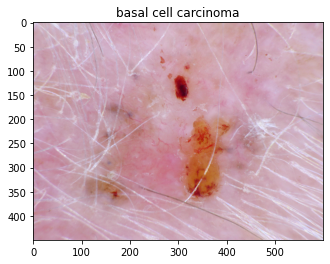

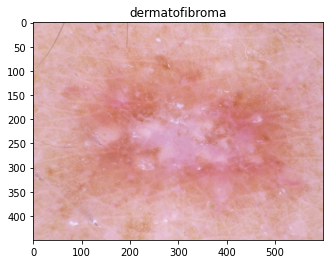

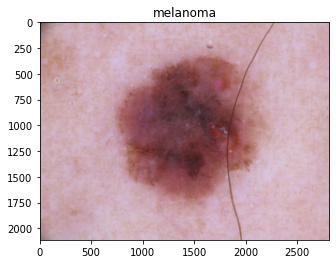

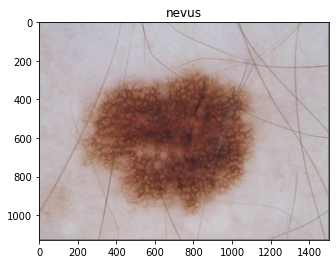

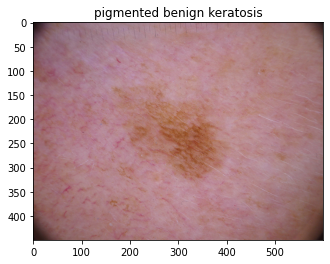

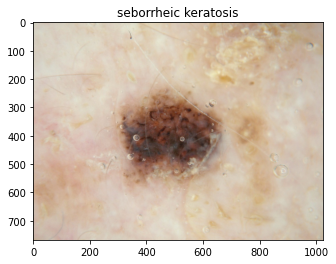

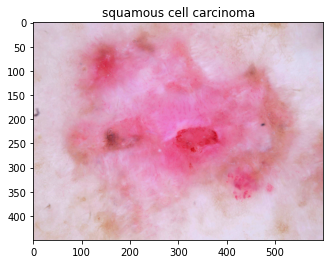

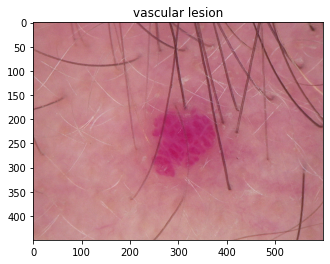

In [ ]:
# method to view image of each of the classes
def view_image(image_path, title=None):
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  if title:
    plt.title(title)
  plt.show()

for index, class_name in enumerate(class_names):
  class_dir = os.path.join(data_dir_train, class_name)
  sample_image_path = os.path.join(class_dir, os.listdir(class_dir)[:10][0])
  view_image(sample_image_path, class_name)
  

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
num_classes = 9

# define model
model = Sequential()

# input layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# layer 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

# layer 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

# layer 3
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

# flatten and dense layer
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01))),

# output layer
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
# compile model
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)        2

### Train the model

In [ ]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 504s 2s/step - loss: 12.4798 - accuracy: 0.3739 - val_loss: 14.4110 - val_accuracy: 0.0403
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 11.0624 - accuracy: 0.5195 - val_loss: 15.5541 - val_accuracy: 0.0403
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 10.6212 - accuracy: 0.6138 - val_loss: 13.0220 - val_accuracy: 0.1253
Epoch 4/20
56/56 [==============================] - 5s 91ms/step - loss: 10.2528 - accuracy: 0.6797 - val_loss: 13.5138 - val_accuracy: 0.1387
Epoch 5/20
56/56 [==============================] - 5s 91ms/step - loss: 9.9091 - accuracy: 0.7321 - val_loss: 12.7391 - val_accuracy: 0.1857
Epoch 6/20
56/56 [==============================] - 5s 91ms/step - loss: 9.5943 - accuracy: 0.7723 - val_loss: 14.6162 - val_accuracy: 0.1544
Epoch 7/20
56/56 [==============================] - 5s 90ms/step - loss: 9.3128 - accuracy: 0.8092 - val_loss: 13.2684 - val_accuracy: 0.1902
Ep

### Visualizing training results

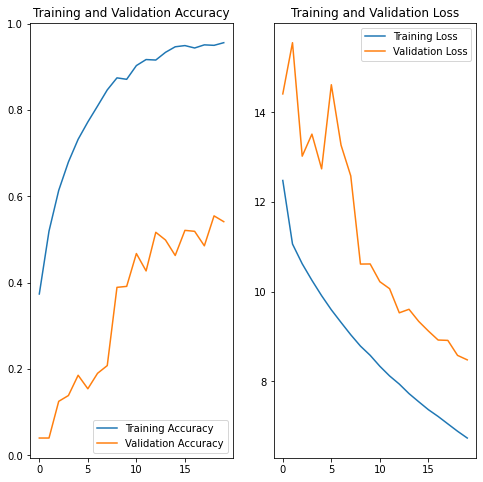

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

1.   There is a significant gap between training and validation accuracy. --> model overfits
2.   Training accuracy keeps on increasing with epochs, while validation accuracy increases first and then the curve flattens.
3. Training loss keeps on decreasing with epochs, while validation loss decreases steeply at first after that loss decreases slowly
4. The training and validation losses have yet not flattened and are still decreasing, this indicates we can use more epochs
5. Dropouts can be tried to deal with the overfitting

**The observations shows that the model overfits and more epochs can be used**


In [13]:
# data augumentation strategy

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width, 3)),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.1),
])

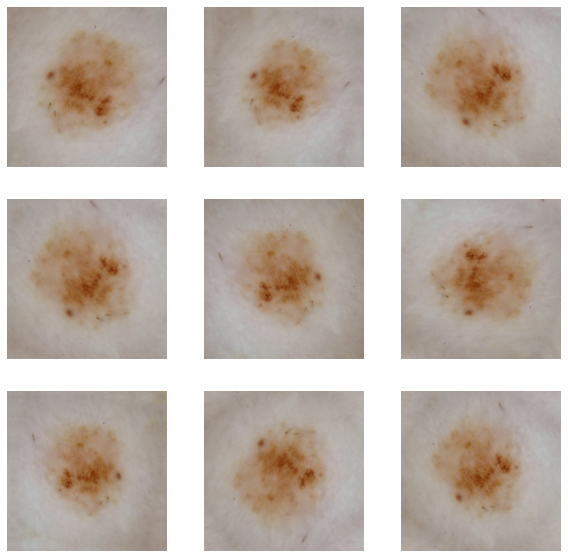

In [ ]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [14]:
'''
Changes from previous layer :
  - data augmentation layer
  - dropout in flatten layer
'''
num_classes = 9

# define model
model = Sequential()

# input layer
model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# layer 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

# layer 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

# layer 3
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

# flatten and dense layer
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01))),
model.add(Dropout(0.40))

# output layer
model.add(Dense(num_classes, activation='softmax'))

### Compiling the model

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)       

In [16]:
# compile model
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [17]:
## train model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 607s 2s/step - loss: 13.2481 - accuracy: 0.3013 - val_loss: 14.1991 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 5s 96ms/step - loss: 11.4320 - accuracy: 0.4169 - val_loss: 13.6728 - val_accuracy: 0.1834
Epoch 3/20
56/56 [==============================] - 5s 95ms/step - loss: 11.0949 - accuracy: 0.4688 - val_loss: 13.6175 - val_accuracy: 0.1790
Epoch 4/20
56/56 [==============================] - 5s 96ms/step - loss: 10.8673 - accuracy: 0.4576 - val_loss: 13.3045 - val_accuracy: 0.1544
Epoch 5/20
56/56 [==============================] - 5s 95ms/step - loss: 10.5824 - accuracy: 0.4821 - val_loss: 12.9835 - val_accuracy: 0.1678
Epoch 6/20
56/56 [==============================] - 5s 95ms/step - loss: 10.3637 - accuracy: 0.5056 - val_loss: 11.4708 - val_accuracy: 0.2260
Epoch 7/20
56/56 [==============================] - 5s 95ms/step - loss: 10.1388 - accuracy: 0.4978 - val_loss: 11.6695 - val_accuracy: 0.2148

### Visualizing the results

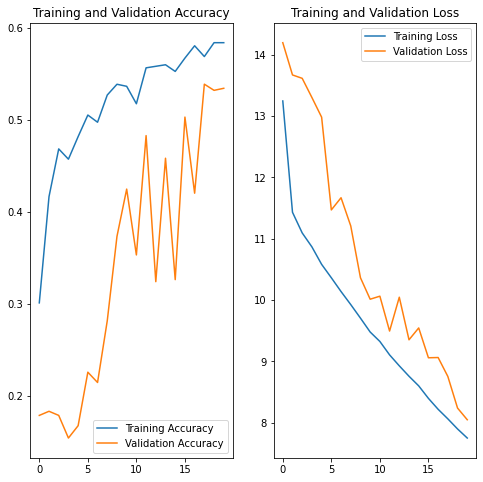

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
- After adding the data augmentation and **dropouts**, the gap between training and validation accuracy is decreased, thus the model doesn't overfit anymore which was the previous issue.
- The training accuracy has decreased from 93 % to 58 %, while validation accuracy remains same at 53 %
- The training and validation losses have yet not flattened and are still decreasing, this indicates we can use more epochs
- The training and validation accuracy are less. This shows model is simpler and underfits.

**Since the model performs poorly on train and test data both, it shows underfitting, which shows that the model is simple hence adding layers can help.**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# class distribution
class_count_dict = {}
count = 0
for image_batch, label_batch in train_ds:
  for label in label_batch:
    label_val = label.numpy()
    count = count + 1
    if label_val not in class_count_dict:
      class_count_dict[label_val] = 1
    else:
        class_count_dict[label_val] = class_count_dict[label_val] + 1
    

,class_count,class
5,370,pigmented benign keratosis
3,352,melanoma
1,309,basal cell carcinoma
4,277,nevus
7,142,squamous cell carcinoma
8,115,vascular lesion
0,92,actinic keratosis
2,77,dermatofibroma
6,58,seborrheic keratosis


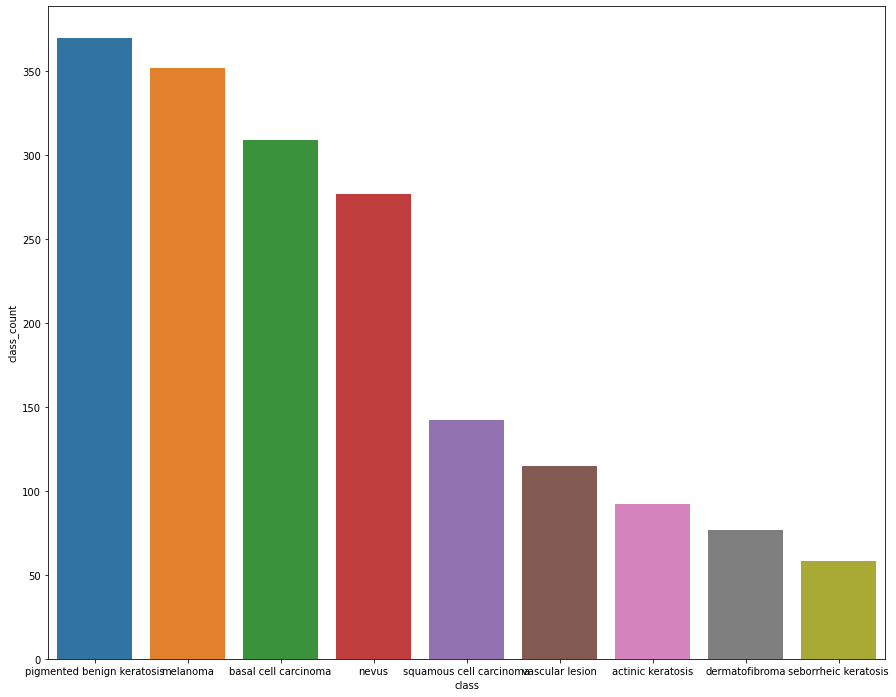

In [ ]:
# plot class distribution
dist_df = pd.DataFrame.from_dict(class_count_dict, orient='index')
dist_df['class_index'] = dist_df.index
dist_df['class_count'] = dist_df[0]
dist_df = dist_df.sort_values(by=["class_count"], ascending=False)
dist_df['class'] = dist_df['class_index'].apply(lambda x : class_names[x])
dist_df.drop(columns=[0, 'class_index'], inplace=True)
plt.figure(figsize=(15,12))
sns.barplot(data=dist_df, x='class', y='class_count')
dist_df

In [19]:
# verify class distribution from number of files in training dir
for dir in os.listdir(data_dir_train):
  print("Dir : {}, Files Count : {}".format(dir, len(os.listdir("Train/"+dir))))

Dir : actinic keratosis, Files Count : 114
Dir : basal cell carcinoma, Files Count : 376
Dir : dermatofibroma, Files Count : 95
Dir : melanoma, Files Count : 438
Dir : nevus, Files Count : 357
Dir : pigmented benign keratosis, Files Count : 462
Dir : seborrheic keratosis, Files Count : 77
Dir : squamous cell carcinoma, Files Count : 181
Dir : vascular lesion, Files Count : 139


### Findings 
#### - Which class has the least number of samples? --> **seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? --> **pigmented benign keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [20]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset=data_dir_train
import Augmentor
for class_name in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, class_name))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AA9951FD0>: 100%|██████████| 500/500 [00:22<00:00, 22.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AA9978290>: 100%|██████████| 500/500 [00:21<00:00, 23.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0AA981BD50>: 100%|██████████| 500/500 [00:22<00:00, 22.29 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0AA9A2DED0>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7F0AA98AA650>: 100%|██████████| 500/500 [01:25<00:00,  5.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AA98CE090>: 100%|██████████| 500/500 [00:21<00:00, 22.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0AA98D28D0>: 100%|██████████| 500/500 [00:48<00:00, 10.27 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AA9810390>: 100%|██████████| 500/500 [00:21<00:00, 22.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AA98E4050>: 100%|██████████| 500/500 [00:23<00:00, 21.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
import glob
path_list = [x for x in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
len(path_list), path_list[0]

(4500,
 PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026709.jpg_342cc794-ea73-4148-bb5c-a709b50d1aba.jpg'))

In [28]:
for dir in os.listdir(data_dir_train):
  print("Dir : {}, Files Count : {}".format(dir, len(os.listdir("Train/"+dir + "/output"))))

Dir : actinic keratosis, Files Count : 500
Dir : basal cell carcinoma, Files Count : 500
Dir : dermatofibroma, Files Count : 500
Dir : melanoma, Files Count : 500
Dir : nevus, Files Count : 500
Dir : pigmented benign keratosis, Files Count : 500
Dir : seborrheic keratosis, Files Count : 500
Dir : squamous cell carcinoma, Files Count : 500
Dir : vascular lesion, Files Count : 500


In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
len(lesion_list_new), lesion_list_new[0]

(4500, 'actinic keratosis')

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
for key, val in dataframe_dict_new.items():
  print("Key : {}, Val : {}".format(key, val))
  break

Key : Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_73aea86f-db85-4df9-a7c1-da436507c5c3.jpg, Val : actinic keratosis


In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2[:2]

,Path,Label
0,Train/actinic keratosis/output/actinic keratos...,actinic keratosis
1,Train/actinic keratosis/output/actinic keratos...,actinic keratosis


In [ ]:
df2['Label'].value_counts()

actinic keratosis             500
melanoma                      500
basal cell carcinoma          500
dermatofibroma                500
nevus                         500
pigmented benign keratosis    500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [32]:
# create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [33]:
# create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [34]:
# class distribution
class_count_dict = {}
count = 0
for image_batch, label_batch in train_ds:
  for label in label_batch:
    label_val = label.numpy()
    count = count + 1
    if label_val not in class_count_dict:
      class_count_dict[label_val] = 1
    else:
        class_count_dict[label_val] = class_count_dict[label_val] + 1

,class_count,class
5,773,pigmented benign keratosis
3,755,melanoma
1,721,basal cell carcinoma
4,677,nevus
7,569,squamous cell carcinoma
8,493,vascular lesion
0,493,actinic keratosis
6,456,seborrheic keratosis
2,455,dermatofibroma


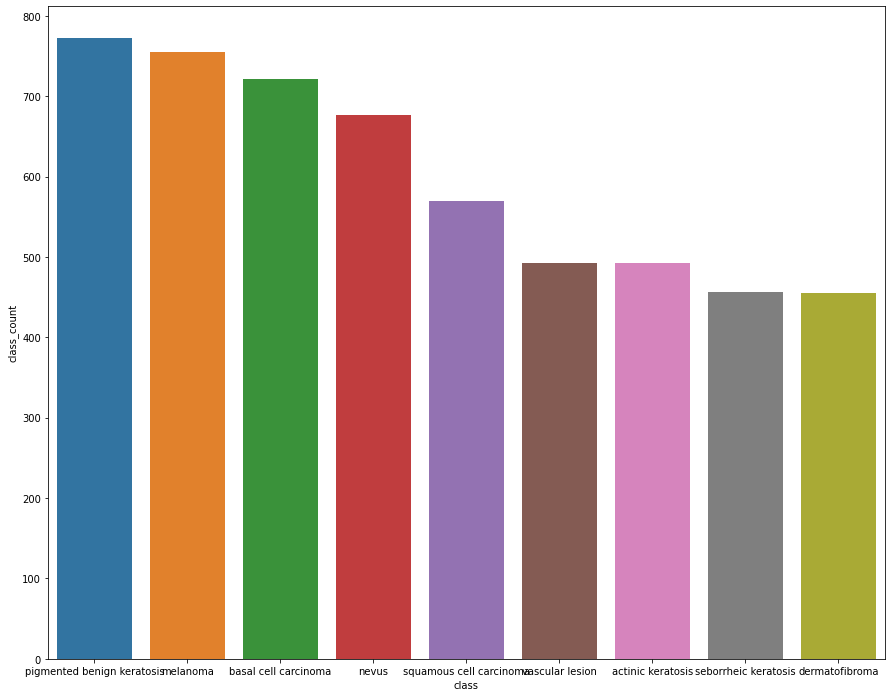

In [35]:
# plot class distribution
dist_df = pd.DataFrame.from_dict(class_count_dict, orient='index')
dist_df['class_index'] = dist_df.index
dist_df['class_count'] = dist_df[0]
dist_df = dist_df.sort_values(by=["class_count"], ascending=False)
dist_df['class'] = dist_df['class_index'].apply(lambda x : class_names[x])
dist_df.drop(columns=[0, 'class_index'], inplace=True)
plt.figure(figsize=(15,12))
sns.barplot(data=dist_df, x='class', y='class_count')
dist_df

#### **Todo:** Create your model (make sure to include normalization)

In [42]:
'''
Changes from previous model:
  - Addition of Conv2D(64, (1, 1)) after preprocessing layer --> to capture finer details
  - Addition of Conv2D(64, (3, 3)) layer
  - Addition of Conv2D(128, (3, 3)) layer 
  - Addition of Conv2D(128, (5, 5)) layer --> to capture bigger details
  - The dense layer size is reduced from 512 to 256 (to reduce the total params)
  - Eventhough the new model has more depth, the number of parameters has reduced from 15.9 mil. to 13.6 mil.
'''
num_classes = 9

# define model
model = Sequential()
model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# layer 1 
model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# layer 2
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# layer 3
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

# layer 4
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# layer 5
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

# layer 6
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# flatten layer
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01))),
model.add(Dropout(0.4))

# output layer
model.add(Dense(num_classes, activation='softmax'))

In [43]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 180, 180, 64)      256       
_________________________________________________________________
batch_normalization_16 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 178, 178, 32)      18464     
_________________________________________________________________
batch_normalization_17 (Batc (None, 178, 178, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)       

In [44]:
# compile model
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
## train model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 58s 310ms/step - loss: 7.3647 - accuracy: 0.3162 - val_loss: 9.1579 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - 52s 300ms/step - loss: 6.2601 - accuracy: 0.4052 - val_loss: 8.6250 - val_accuracy: 0.1180
Epoch 3/50
169/169 [==============================] - 52s 302ms/step - loss: 5.8715 - accuracy: 0.4408 - val_loss: 7.6898 - val_accuracy: 0.2042
Epoch 4/50
169/169 [==============================] - 52s 300ms/step - loss: 5.5394 - accuracy: 0.4533 - val_loss: 5.7079 - val_accuracy: 0.3779
Epoch 5/50
169/169 [==============================] - 52s 301ms/step - loss: 5.2373 - accuracy: 0.4792 - val_loss: 5.1504 - val_accuracy: 0.4959
Epoch 6/50
169/169 [==============================] - 48s 279ms/step - loss: 4.9509 - accuracy: 0.4855 - val_loss: 4.9026 - val_accuracy: 0.4959
Epoch 7/50
169/169 [==============================] - 48s 278ms/step - loss: 4.7014 - accuracy: 0.5121 - val_loss: 4.7660 - val_ac

#### **Todo:**  Visualize the model results

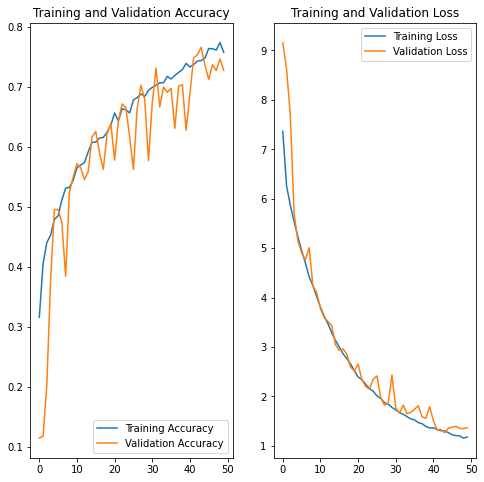

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Did you get rid of underfitting/overfitting? Did class rebalance help?



1. After changing the neural net architecture and adding augmented images, the underfitting problem was solved, so the class rebalance with the new architecture helped. This can be seen as the gap between training and validation accuracy is narrower now.
2. The fluctuations in the validation accuracy have reduced from previous iteration.
3. The validation loss has almost flattened out, however increasing the learning rate can help in reaching the plateau faster and the accuracy can increase a bit more.

**Next Steps :**
- Increase learning rate and observe effects
- Add a 256 x (3,3) kernel and observe effects 

